In [157]:
import os, sys, shutil, copy
import random, math
import numpy as np
import json
import cv2
from matplotlib import pyplot as plt

In [9]:
sys.path.append("../")
%load_ext autoreload
%autoreload 2

In [122]:
from utils.utils import makeMini, myPlot, answerToPoints, meanTruth
from scorer_scripts_v2.scorer_scripts_v2.score_detections import score
from starter_scripts_v2.starter_scripts_v2.helper import plot_bbox

##### Make Mini Img-Set / Copy Files

In [74]:
makeMini(N=10)

../mini/mini1
10
['IMG_0160.JPG', 'IMG_0696.JPG', 'IMG_3751.JPG']...
output truth  truth.json


##### find average of img-set

In [80]:
#load truth
p_truth = '../training_GT_labels_v2.json'
with open(p_truth, 'r') as f:
    truth = json.load(f)

In [101]:
means = meanTruth(truth)
means

[529.1341332761946,
 335.0982429826441,
 727.459074351832,
 334.7421255624598,
 728.5013927576601,
 597.3908292264838,
 527.4163274051854,
 598.7229483608314]

In [123]:
files = os.listdir('../mini/mini1/')
files = filter(lambda f: '.JPG' in f, files)

predict_mini = {}
for fn in files:
    predict_mini[str(fn)] = [copy.copy(means)]

In [124]:
# score using global mean
truth_fn = '../mini/mini1/truth.json'
with open(truth_fn, 'r') as f:
    truth_mini = json.load(f)
score_mini = score(d_predict = predict_mini, d_truth = truth_mini)
score_mini

10 10
COCO mAP for detector is 0.170606060606


0.17060606060606057

In [125]:
# curiosuly - current-set avg performs worse on mAP then 
mini_means = meanTruth(truth_mini)
print mini_means
predict_mini2 = {}
for fn in files:
    predict_mini2[str(fn)] = [copy.copy(mini_means)]
score_mini2 = score(d_predict = predict_mini2, d_truth = truth_mini)
score_mini2

[580.1, 375.4, 732.9, 378.7, 733.6, 560.2, 580.6, 560.2]
10 10
COCO mAP for detector is 0.155743145743


0.1557431457431457

##### Pred-actual on mini

In [158]:
score(d_truth=truth_mini, d_predict=truth_mini)

1.0

##### Gradient Descent

In [126]:
def newVals(d, val):
    for k in d:
        d[k] = val
    return d

In [133]:
score_list = []
for ind in range(8):
    for delta in [-5,-1,0,1,5]:
        
        new_means = copy.copy(mini_means)
        new_means[ind] += delta
        
        predict_new = newVals(copy.deepcopy(truth_mini), [copy.copy(new_means)])
        
        _score = score(d_predict=predict_new, d_truth=truth_mini)
        
        score_triple = [ind, delta, _score]
        
        score_list.append(score_triple)
                
score_list.sort(key=lambda e: e[2], reverse=True)
score_list[:3]

[[0, 5, 0.16685425685425684],
 [2, -5, 0.16685425685425684],
 [3, -5, 0.16685425685425684]]

In [141]:
current_means

[585.1, 375.4, 732.9, 378.7, 733.6, 560.2, 580.6, 560.2]

In [156]:
current_means = copy.copy(mini_means)
current_score = 0
iter_list = []

# this must be wrong somewhere?

for _i in range(10):
    
    score_list = []
    for ind in range(8):
        for delta in [-20,-10,-5,-1,0,1,5,10, 20]:

            new_means = copy.copy(current_means)
            new_means[ind] += delta

            predict_new = newVals(copy.deepcopy(truth_mini), [copy.copy(new_means)])

            _score = score(d_predict=predict_new, d_truth=truth_mini)

            score_triple = [ind, delta, _score]

            score_list.append(score_triple)

    score_list.sort(key=lambda e: e[2], reverse=True)
    
    # print score_list[:5]
    best_point = score_list[0]
    
    best_ind, best_delta = best_point[0], best_point[1]
    best_score = best_point[2]

    if best_score <= current_score:
        break
        
    current_score = best_score
    
    current_means[best_ind] += best_delta
    
    tmp_point = copy.copy(best_point)
    tmp_point.append(copy.copy(current_means))
    iter_list.append(tmp_point)
    
    print _i
    
iter_list


0
1
2


[[2,
  20,
  0.17483405483405484,
  [580.1, 375.4, 752.9, 378.7, 733.6, 560.2, 580.6, 560.2]],
 [3,
  -20,
  0.19877344877344877,
  [580.1, 375.4, 752.9, 358.7, 733.6, 560.2, 580.6, 560.2]],
 [0,
  20,
  0.2116161616161616,
  [600.1, 375.4, 752.9, 358.7, 733.6, 560.2, 580.6, 560.2]]]

this doesn't make sense to always do delta=20 and then never find another delta<20

oh maybe due to step sizes in coco score

In [154]:
new_means = iter_list[2][3]
predict_opt = newVals(copy.deepcopy(truth_mini), [copy.copy(new_means)])
score_opt = score(d_predict = predict_opt, d_truth = truth_mini)
score_opt

0.2116161616161616

##### plot utils

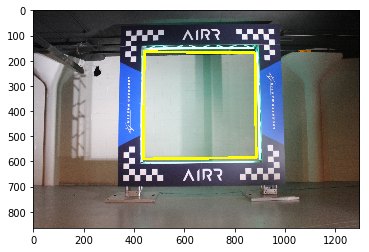

IMG_0029.JPG
[[440 165]
 [879 169]
 [884 584]
 [437 590]]


In [85]:
myPlot(10, truth)

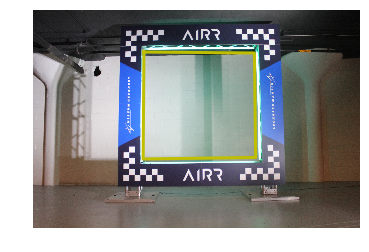

In [99]:
img_path = '../Data_Training/Data_Training/'
img_fn = 'IMG_0029.JPG'
img_pfn = img_path + img_fn
img = cv2.imread(img_pfn)
img = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2RGB)
bbox = truth[img_fn]

plot_bbox(img, bbox, color='y')
plt.show()